# Global ms diagnosis on main combination
- compute MSRe, nMSRe, $C_{\alpha}$, captured physical signal and error parts
- evaluate H1

In [7]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_closure_bar, plot_cor_uncor_part
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

In [8]:
DL =25*1e3 #meters
DT = 1800.0 #seconds
id_aviso = 'aviso__0__adt__es_cstrio_z15__alti_x'
id_co = 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x'

# Datasets 

In [9]:
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

ds, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' ()>
array(146030)


In [10]:
dsms.sel(drifter_sat_year='gps_Sentinel-3_A_2019')

<xarray.Dataset>
Dimensions:                                                                                   (
                                                                                               id_comb: 80)
Coordinates:
    drifter_sat_year                                                                          <U32 ...
  * id_comb                                                                                   (id_comb) <U75 ...
Data variables: (12/425)
    alti_ggx_adt_filtered                                                                     float64 ...
    alti_ggx_adt_filtered_ocean_tide                                                          float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide                                            float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide_dac                                        float64 ...
    aviso_alti_ggx_adt                                                                        float64 ...
    aviso_drifter_ggx_adt                                                                     float64 ...
    ...                                                                                        ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__alti_x                                 float64 ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__drifter_x                              float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x                   float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x                float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__alti_x               float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__drifter_x            float64 ...

______________________
# Closure efficiancy : MSRe $\langle S^2 \rangle$ and $nMSRe = \frac{\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
- AVISO more efficient

In [11]:
print('Along-track')
print('MSRe = ' + f"{ds['sum_'+id_co].values,mserr['sum_'+id_co].values }")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_co)}")
print('AVISO')
print('ReMS = ' + f"{ds['sum_'+id_aviso].values, mserr['sum_'+id_aviso].values}")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_aviso)}")

Along-track
MSRe = (array(2.34695418e-10), array(2.23726313e-12))
nMSRe = (array(27.75727771), array(0.52919938))
AVISO
ReMS = (array(2.20274724e-10), array(2.09979611e-12))
nMSRe = (array(30.58597269), array(0.58312915))


Text(0, 0.5, 'MSRE $[m^2/s^4]$')

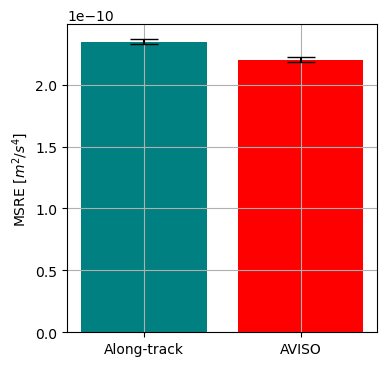

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, ds['sum_'+id_co], yerr =mserr['sum_'+id_co],  color ='teal',width = 0.4, capsize=10)
ax.bar(1, ds['sum_'+id_aviso], yerr =mserr['sum_'+id_aviso], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'MSRE $[m^2/s^4]$')

Text(0, 0.5, '$nMSRe$ [%]')

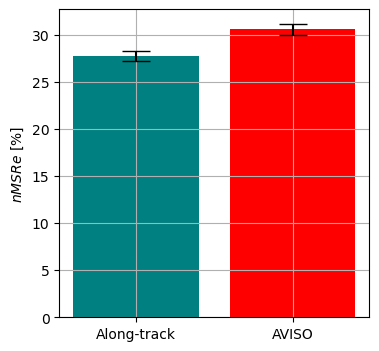

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, nMSRe_id(ds,mserr, id_co)[0],yerr = nMSRe_id(ds,mserr, id_co)[1], color ='teal',width = 0.4, capsize=10)
ax.bar(1, nMSRe_id(ds,mserr, id_aviso)[0], yerr = nMSRe_id(ds, mserr,id_aviso)[1], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$nMSRe$ [%]')

______________________
# $x$ contribution : $C_{\alpha} =\langle S_{-\alpha_i}^2\rangle-\langle S^2 \rangle$  and $Rc_{\alpha_i} = \frac{\langle S_{-\alpha_i}^2\rangle-\langle S^2 \rangle}{\sum_i \langle \alpha_i^2 \rangle}$

In [14]:
CX = C_x(ds,mserr, [id_co, id_aviso])

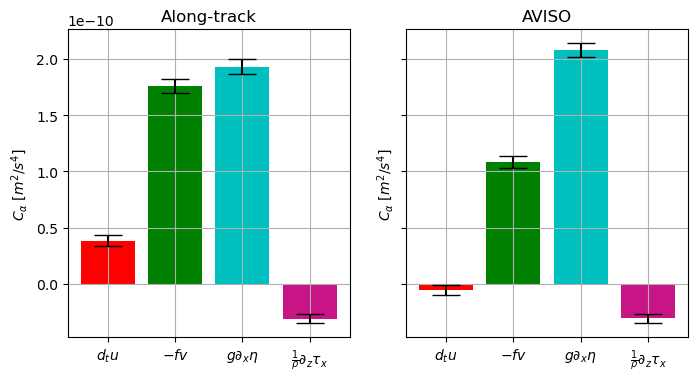

In [15]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(8,4), sharey=True)
ax=axs[0]
df = CX.loc[id_co]
ax.bar(0.5, df.acc, yerr=df.acc_err, color ='r',width = 0.4, capsize=10)
ax.bar(1, df.coriolis,yerr=df.coriolis_err, color ='g',width = 0.4, capsize=10)
ax.bar(1.5, df.ggrad,yerr=df.ggrad_err, color ='c',width = 0.4, capsize=10)
ax.bar(2, df.wind,yerr=df.wind_err, color ='mediumvioletred',width = 0.4, capsize=10)
ax.set_title('Along-track')

ax=axs[1]
df = CX.loc[id_aviso]
ax.bar(0.5, df.acc,yerr=df.acc_err, color ='r',width = 0.4, capsize=10)
ax.bar(1, df.coriolis,yerr=df.coriolis_err, color ='g',width = 0.4, capsize=10)
ax.bar(1.5, df.ggrad,yerr=df.ggrad_err, color ='c',width = 0.4, capsize=10)
ax.bar(2, df.wind,yerr=df.wind_err, color ='mediumvioletred',width = 0.4, capsize=10)
ax.set_title('AVISO')

for ax in axs :
    ax.grid()
    ticks = (r'$d_tu$', r'$-fv$', r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks([0.5, 1, 1.5, 2], ticks,)
    ax.set_ylabel(r'$C_{\alpha}$ $[m^2/s^4]$')
    

acc:1.41960071804602e-10, coriolis:3.733266696024616e-10, ggrad:3.122782341767954e-10, wind:1.7962529751309902e-11
acc:1.41960071804602e-10, coriolis:3.733266696024616e-10, ggrad:1.8693290441633343e-10, wind:1.7962529751309902e-11


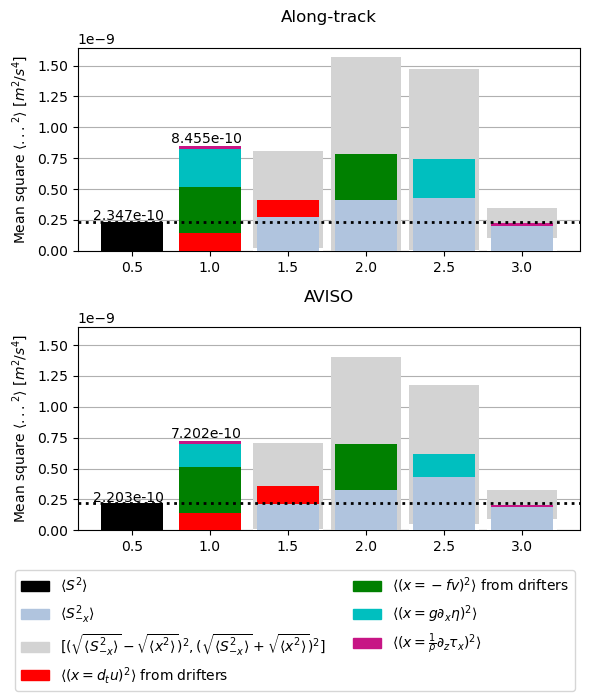

In [16]:
fig_title=1
fig, axs = plt.subplots(nrows=2,ncols=1,
                            sharey='all',
                            figsize=(6,7))
plot_closure_bar(ds, id_co ,axs[0], title = 'Along-track')
plot_closure_bar(ds, id_aviso,axs[1], title = 'AVISO')


if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=2,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.18,1,1])#left, bottom, right, top (default is 0,0,1,1)

________________________
# True/Error in $\alpha$ 
$\langle \hat{\alpha_i} \rangle +\langle \hat{\alpha_i}{\alpha_i^{e}}^2 \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle - \langle S^2 \rangle +\langle S_{-\alpha_i}^2 \rangle) $  

$\langle {\alpha_i^{e}}^2 \rangle+\langle \hat{\alpha_i}{\alpha_i^{e}}^2 \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle + \langle S^2 \rangle -\langle S_{-\alpha_i}^2 \rangle) $
## Under H1

$\langle \hat{\alpha_i} \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle - \langle S^2 \rangle +\langle S_{-\alpha_i}^2 \rangle) $  

$\langle {\alpha_i^{e}}^2 \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle + \langle S^2 \rangle -\langle S_{-\alpha_i}^2 \rangle) $

In [17]:
dsms = xr.concat([true_err_x(ds,mserr, id_co), true_err_x(ds,mserr, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

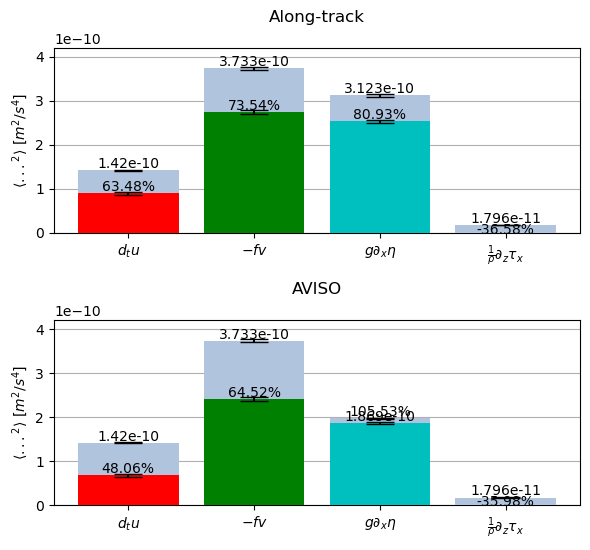

In [18]:
fig_title=1
fig, axs = plt.subplots(nrows=2,ncols=1,
                            sharey='all',
                            figsize=(6,7))
plot_cor_uncor_part(dsms.sel(id_comb=id_co), ax=axs[0], title ='Along-track')
plot_cor_uncor_part(dsms.sel(id_comb=id_aviso), ax=axs[1], title ='AVISO')
axs[0].set_ylim(0,4.2e-10)
axs[0].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
axs[1].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

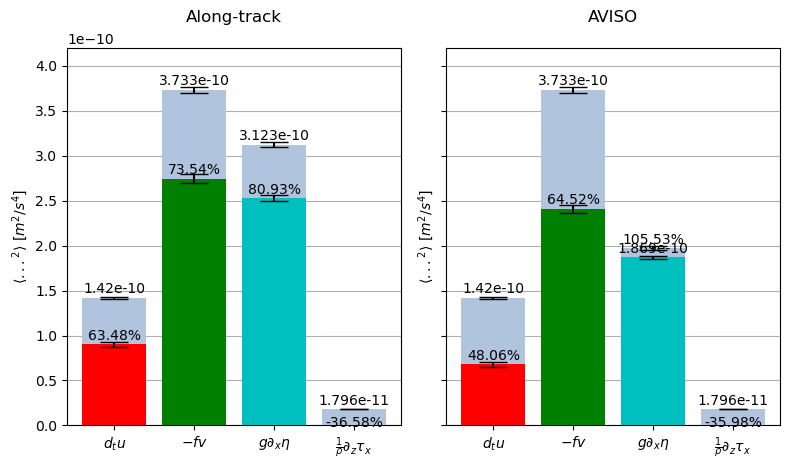

In [19]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(8,6))
plot_cor_uncor_part(dsms.sel(id_comb=id_co), ax=axs[0], title ='Along-track')
plot_cor_uncor_part(dsms.sel(id_comb=id_aviso), ax=axs[1], title ='AVISO')
axs[0].set_ylim(0,4.2e-10)
axs[0].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
axs[1].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

## Validité erreurs non corrélées :

- erreurs coriolis/acceleration doivent être correlées -> possible de le voir ?


$$ \langle S^2 \rangle - \sum_i A_{x_i} = \sum_x \langle \hat{x}x_e \rangle + \sum_i\sum_{j\neq i}[\langle {x_e}_i{x_e}_j \rangle + 2\langle {x_e}_i\hat{x}_j \rangle + \langle \hat{x}_i{x_e}_j \rangle] $$

In [20]:
dsmm = dsms*1e10

In [21]:
A = dsmm['err_acc']+dsmm['err_ggrad']+dsmm['err_wind']+dsmm['err_coriolis']

In [22]:
((A-dsmm['S'])/dsmm['S'])

<xarray.DataArray (id_comb: 2)>
array([ 3.78438756e-16, -2.01606976e-16])
Coordinates:
  * id_comb  (id_comb) object 'co__0__adt_filtered_ocean_tide_internal_tide__...

In [23]:
dsmm['S']

<xarray.DataArray 'S' (id_comb: 2)>
array([2.34695418, 2.20274724])
Coordinates:
  * id_comb  (id_comb) object 'co__0__adt_filtered_ocean_tide_internal_tide__...